Поиск цен на момент покупки...

Учтено покупок после поиска цен: 4
Расчет относительной стоимости портфеля...
Расчет завершен.


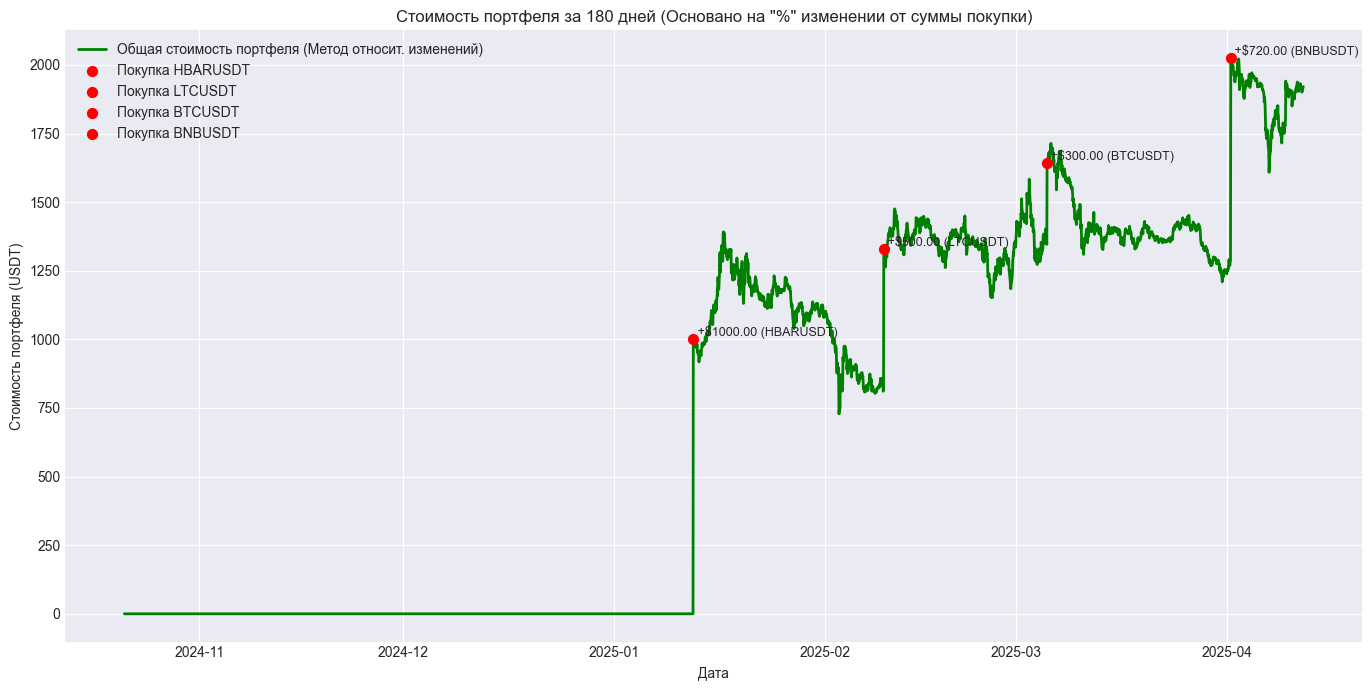


Данные портфеля с найденными ценами покупки:
                 Дата     Актив  Общая стоимость  Purchase_Price_Actual  \
0 2025-01-12 14:29:48  HBARUSDT           1000.0                0.28239   
1 2025-02-09 14:21:24   LTCUSDT            500.0              108.02000   
2 2025-03-05 14:21:17   BTCUSDT            300.0            88344.25000   
3 2025-04-01 14:21:01   BNBUSDT            720.0              615.26000   

  Actual_Purchase_Time_Index  
0        2025-01-12 15:00:00  
1        2025-02-09 15:00:00  
2        2025-03-05 15:00:00  
3        2025-04-01 15:00:00  

Рассчитанные данные портфеля (последние 5 записей):
                     Total_Value_Relative  HBARUSDT_Price  LTCUSDT_Price  \
Open time                                                                  
2025-04-12 03:00:00           1903.455886         0.16620          75.29   
2025-04-12 04:00:00           1910.445666         0.16679          75.83   
2025-04-12 05:00:00           1912.913589         0.16714         

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Настройки ---
days_history = 180
# Укажите "сегодняшнюю" дату для отсчета истории назад
today = pd.Timestamp('2025-04-19')
# Либо, если ваши CSV обновляются, можно брать последнюю дату из данных:
# today = None # Раскомментируйте, если хотите использовать последнюю дату из данных

# --- Шаг 1: Загрузка данных о портфеле (используем только Дату, Актив, Общую стоимость) ---
portfolio_data = {
    "ID": [3, 2, 1, 0],
    "Дата": ["2025-01-12T14:29:48.000", "2025-02-09T14:21:24.000", "2025-03-05T14:21:17.000", "2025-04-01T14:21:01.000"],
    "Тип": ["Покупка", "Покупка", "Покупка", "Покупка"], # Не используется
    "Актив": ["HBARUSDT", "LTCUSDT", "BTCUSDT", "BNBUSDT"], # Нужно для связи с ценами
    "Количество": [4667.50014884, 131.38877940, 0.01195125, 1.70157736], # НЕ ИСПОЛЬЗУЕТСЯ
    "Цена": [0.17, 76.11, 83.26, 58.69], # НЕ ИСПОЛЬЗУЕТСЯ
    "Комиссия": [0.00, 0.00, 0.00, 0.00], # Не используется
    "Общая стоимость": [1000.00, 500.00, 300.00, 720.00] # КЛЮЧЕВОЙ ПАРАМЕТР
}
portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df['Дата'] = pd.to_datetime(portfolio_df['Дата'])
# Сортировка ОЧЕНЬ важна для правильной обработки покупок
portfolio_df = portfolio_df.sort_values(by='Дата').reset_index(drop=True)

# --- Шаг 2: Загрузка исторических данных активов ---
try:
    # Укажите ПРАВИЛЬНЫЕ пути к вашим файлам CSV
    btc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BTCUSDT_hourly_data.csv')
    bnb_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BNBUSDT_hourly_data.csv')
    ltc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\LTCUSDT_hourly_data.csv')
    hbar_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\HBARUSDT_hourly_data.csv')
except FileNotFoundError as e:
    print(f"Ошибка: Файл не найден. Проверьте путь: {e}")
    exit()

def preprocess_data(df, asset_name):
    df['Open time'] = pd.to_datetime(df['Open time'])
    df = df.set_index('Open time')
    # Нам нужен только столбец Close для цен
    df = df[['Close']].rename(columns={'Close': f'{asset_name}_Price'})
    # Явно указываем тип float
    df[f'{asset_name}_Price'] = df[f'{asset_name}_Price'].astype(float)
    return df

btc_data = preprocess_data(btc_data, 'BTCUSDT')
bnb_data = preprocess_data(bnb_data, 'BNBUSDT')
ltc_data = preprocess_data(ltc_data, 'LTCUSDT')
hbar_data = preprocess_data(hbar_data, 'HBARUSDT')

# Объединение данных по ценам
historical_prices = pd.concat([btc_data, bnb_data, ltc_data, hbar_data], axis=1)

# Определяем временной диапазон
if today is None:
    today = historical_prices.index.max() # Берем последнюю дату из данных
start_date_history = today - pd.Timedelta(days=days_history)

# --- Шаг 3: Фильтрация, подготовка и расчет стоимости (Метод относительных изменений) ---

# Фильтрация объединенных данных по заданному ИСТОРИЧЕСКОМУ диапазону
historical_prices_filtered = historical_prices[(historical_prices.index >= start_date_history) & (historical_prices.index <= today)].copy()
# Используем .copy() чтобы избежать SettingWithCopyWarning

# Заполнение возможных пропусков (важно перед поиском цен покупки)
historical_prices_filtered = historical_prices_filtered.ffill().bfill()

# Проверка на наличие NaN после заполнения
if historical_prices_filtered.isnull().values.any():
    print("Предупреждение: В исторических данных остались пропуски (NaN) после заполнения.")
    print(historical_prices_filtered[historical_prices_filtered.isnull().any(axis=1)])
    # Можно либо удалить строки с NaN, либо применить другую стратегию
    historical_prices_filtered = historical_prices_filtered.dropna()

# Добавляем столбцы для хранения цены покупки и индекса времени для каждой транзакции
portfolio_df['Purchase_Price_Actual'] = np.nan
portfolio_df['Actual_Purchase_Time_Index'] = pd.NaT

# Находим фактическую цену в исторических данных НА МОМЕНТ ПОКУПКИ или сразу после
print("Поиск цен на момент покупки...")
for index, row in portfolio_df.iterrows():
    asset = row['Актив']
    purchase_date = row['Дата']
    price_col = f'{asset}_Price'

    if price_col not in historical_prices_filtered.columns:
        print(f"Ошибка: Столбец цен {price_col} не найден для актива {asset}.")
        continue # Пропускаем эту покупку

    # Ищем первый индекс времени в historical_prices_filtered >= даты покупки
    relevant_prices = historical_prices_filtered[historical_prices_filtered.index >= purchase_date]

    if not relevant_prices.empty:
        actual_purchase_time_index = relevant_prices.index[0]
        purchase_price = relevant_prices.loc[actual_purchase_time_index, price_col]

        # Проверка, что цена не NaN и не 0
        if pd.notna(purchase_price) and purchase_price > 0:
            portfolio_df.loc[index, 'Purchase_Price_Actual'] = purchase_price
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = actual_purchase_time_index
            # print(f"  Для {asset} ({purchase_date}): Найдена цена {purchase_price:.4f} на {actual_purchase_time_index}")
        else:
            print(f"Предупреждение: Найдена некорректная цена ({purchase_price}) для {asset} на {actual_purchase_time_index}. Покупка будет проигнорирована.")
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT # Помечаем как недействительное

    else:
        # Если дата покупки позже всех исторических данных, покупку нельзя учесть
        print(f"Предупреждение: Не найдены исторические данные для {asset} на или после {purchase_date}. Покупка будет проигнорирована.")
        portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT # Помечаем как недействительное

# Удаляем строки из портфеля, для которых не удалось найти действительное время/цену покупки
portfolio_df.dropna(subset=['Actual_Purchase_Time_Index', 'Purchase_Price_Actual'], inplace=True)

print(f"\nУчтено покупок после поиска цен: {len(portfolio_df)}")
if len(portfolio_df) == 0:
      print("Ошибка: Не найдено действительных покупок для анализа. Проверьте даты и наличие данных.")
      exit()

# Инициализируем столбец общей стоимости нулями
historical_prices_filtered['Total_Value_Relative'] = 0.0

# Рассчитываем стоимость для каждого момента времени
print("Расчет относительной стоимости портфеля...")
# Итерируемся по временным меткам в отфильтрованных данных
for current_time_index in historical_prices_filtered.index:
    current_total_value = 0.0
    # Итерируемся по каждой ДЕЙСТВИТЕЛЬНОЙ покупке в портфеле
    for _, purchase_row in portfolio_df.iterrows():
        purchase_time_index = purchase_row['Actual_Purchase_Time_Index'] # Фактическое время из индекса цен

        # Учитываем покупку только если текущее время >= времени покупки
        if current_time_index >= purchase_time_index:
            initial_investment = purchase_row['Общая стоимость'] # Берем исходную сумму
            purchase_price = purchase_row['Purchase_Price_Actual'] # Цена в момент покупки
            asset = purchase_row['Актив']
            price_col = f'{asset}_Price'

            # Получаем текущую цену актива
            current_price = historical_prices_filtered.loc[current_time_index, price_col]

            # Рассчитываем текущую стоимость этой конкретной инвестиции
            # на основе ПРОЦЕНТНОГО изменения цены с момента покупки
            if pd.notna(current_price): # Проверяем, что текущая цена действительна
                # Коэффициент изменения цены (Current Price / Purchase Price)
                price_ratio = current_price / purchase_price # purchase_price уже проверена > 0
                current_investment_value = initial_investment * price_ratio
            else:
                # Если текущая цена неизвестна, сохраняем последнюю известную стоимость
                # Найдем предыдущий индекс
                prev_index = historical_prices_filtered.index[historical_prices_filtered.index < current_time_index]
                if not prev_index.empty:
                     # Повторяем расчет для предыдущего индекса (приблизительно)
                     # Это сложная логика, проще считать вклад 0 или оставить как есть
                     prev_price = historical_prices_filtered.loc[prev_index[-1], price_col]
                     if pd.notna(prev_price):
                          price_ratio = prev_price / purchase_price
                          current_investment_value = initial_investment * price_ratio
                     else: # Если и предыдущая цена NaN
                          current_investment_value = 0 # Безопасное значение по умолчанию
                else: # Если это самая первая точка
                     current_investment_value = 0 # Безопасное значение по умолчанию
                print(f"Предупреждение: Отсутствует текущая цена для {asset} на {current_time_index}. Используется приближенное значение.")


            # Добавляем стоимость этой инвестиции к общей стоимости на текущий момент
            current_total_value += current_investment_value

    # Записываем общую стоимость для текущего времени
    historical_prices_filtered.loc[current_time_index, 'Total_Value_Relative'] = current_total_value

print("Расчет завершен.")

# --- Шаг 4: Визуализация ---
plt.style.use('seaborn-v0_8-darkgrid') # Используем стиль для лучшего вида
plt.figure(figsize=(14, 7))

plt.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Relative'],
         label='Общая стоимость портфеля (Метод относит. изменений)', color='green', linewidth=2)

# Добавим отметки о покупках
unique_labels = set() # Для уникальных меток в легенде
portfolio_in_range = portfolio_df[portfolio_df['Actual_Purchase_Time_Index'] >= start_date_history]

for index, row in portfolio_in_range.iterrows():
    plot_time = row['Actual_Purchase_Time_Index']
    # Ищем точное значение в индексе для корректного отображения
    if plot_time in historical_prices_filtered.index:
        # Стоимость портфеля СРАЗУ ПОСЛЕ добавления этой инвестиции
        value_at_purchase = historical_prices_filtered.loc[plot_time, 'Total_Value_Relative']
        label_text = f'Покупка {row["Актив"]}'
        # Добавляем метку в легенду только один раз для каждого типа события
        current_label = label_text if label_text not in unique_labels else ""
        if current_label: unique_labels.add(label_text)

        plt.scatter(plot_time, value_at_purchase, color='red', s=50, zorder=5, label=current_label) # s - размер точки
        # Текст с названием актива и суммой покупки
        plt.text(plot_time + pd.Timedelta(hours=1), value_at_purchase, # Смещаем текст чуть вправо
                 f" +${row['Общая стоимость']:.2f} ({row['Актив']})",
                 fontsize=9, verticalalignment='bottom', horizontalalignment='left')
    else:
         # Это не должно происходить, если проверка на NaN была успешной
         print(f"Предупреждение: Не удалось найти индекс {plot_time} для отметки покупки {row['Актив']}")


plt.title(f'Стоимость портфеля за {days_history} дней (Основано на "%" изменении от суммы покупки)')
plt.xlabel('Дата')
plt.ylabel('Стоимость портфеля (USDT)')
plt.grid(True)

# Создаем легенду, избегая дубликатов
handles, labels = plt.gca().get_legend_handles_labels()
# Убираем дубликаты, сохраняя порядок
from collections import OrderedDict
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout() # Улучшает размещение элементов
plt.show()

# Вывод данных для проверки
print("\nДанные портфеля с найденными ценами покупки:")
print(portfolio_df[['Дата', 'Актив', 'Общая стоимость', 'Purchase_Price_Actual', 'Actual_Purchase_Time_Index']])

print(f"\nРассчитанные данные портфеля (последние 5 записей):")
# Показываем итоговую стоимость и цены активов для сравнения
price_cols_to_show = [f'{a}_Price' for a in portfolio_df['Актив'].unique() if f'{a}_Price' in historical_prices_filtered.columns]
print(historical_prices_filtered[['Total_Value_Relative'] + price_cols_to_show].tail())

print(f"\nРассчитанные данные портфеля (первые 5 записей):")
print(historical_prices_filtered[['Total_Value_Relative'] + price_cols_to_show].head())

Поиск цен на момент покупки...
Расчет кумулятивной стоимости...
Расчет вклада и P&L для каждой покупки...
Расчеты завершены.


C:\Users\igora\AppData\Local\Temp\ipykernel_13200\1422278249.py:173: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(purchase_pnl_cols)) # tab20 - хорошая палитра для различимых цветов


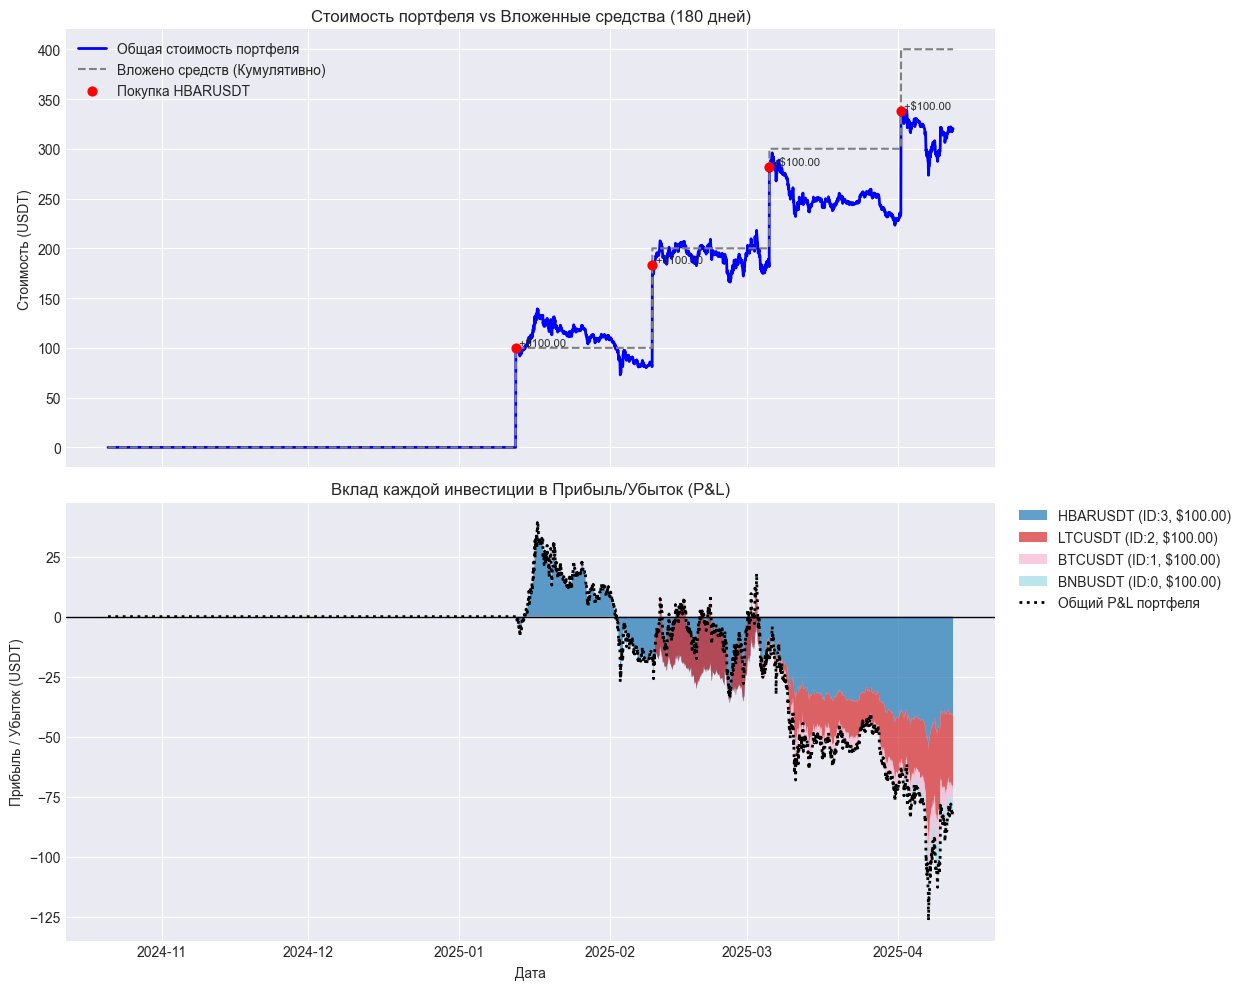


Данные портфеля с найденными ценами:
   ID                Дата     Актив  Общая стоимость  Purchase_Price_Actual  \
0   3 2025-01-12 14:29:48  HBARUSDT            100.0                0.28239   
1   2 2025-02-09 14:21:24   LTCUSDT            100.0              108.02000   
2   1 2025-03-05 14:21:17   BTCUSDT            100.0            88344.25000   
3   0 2025-04-01 14:21:01   BNBUSDT            100.0              615.26000   

  Actual_Purchase_Time_Index  
0        2025-01-12 15:00:00  
1        2025-02-09 15:00:00  
2        2025-03-05 15:00:00  
3        2025-04-01 15:00:00  

Рассчитанные данные портфеля (последние 5 записей):
                     Cumulative_Cost  Total_Value_Relative  Total_PnL  \
Open time                                                               
2025-04-12 03:00:00            400.0            317.564950 -82.435050   
2025-04-12 04:00:00            400.0            318.762361 -81.237639   
2025-04-12 05:00:00            400.0            319.143348 -80.856

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict # Для уникальных меток в легенде

# --- Настройки ---
days_history = 180
today = pd.Timestamp('2025-04-19')
# today = None # Для использования последней даты из данных

# --- Шаг 1: Загрузка данных о портфеле ---
portfolio_data = {
    "ID": [2, 0, 1, 3], # ID могут быть произвольными
    "Дата": ["2025-02-09T14:21:24.000", "2025-04-01T14:21:01.000", "2025-03-05T14:21:17.000", "2025-01-12T14:29:48.000"], # УКАЖИТЕ ВАШИ РЕАЛЬНЫЕ ДАТЫ ПОКУПОК!
    "Актив": ["LTCUSDT", "BNBUSDT", "BTCUSDT", "HBARUSDT"],
    "Общая стоимость": [100.00, 100.00, 100.00, 100.00] # КЛЮЧЕВОЙ ПАРАМЕТР
    # Остальные столбцы из исходных данных портфеля не нужны для этого расчета
}
portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df['Дата'] = pd.to_datetime(portfolio_df['Дата'])
portfolio_df = portfolio_df.sort_values(by='Дата').reset_index(drop=True)

# --- Шаг 2: Загрузка исторических данных ---
try:
    # Укажите ПРАВИЛЬНЫЕ пути
    btc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BTCUSDT_hourly_data.csv')
    bnb_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BNBUSDT_hourly_data.csv')
    ltc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\LTCUSDT_hourly_data.csv')
    hbar_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\HBARUSDT_hourly_data.csv')
except FileNotFoundError as e:
    print(f"Ошибка: Файл не найден. Проверьте путь: {e}")
    exit()

def preprocess_data(df, asset_name):
    df['Open time'] = pd.to_datetime(df['Open time'])
    df = df.set_index('Open time')
    df = df[['Close']].rename(columns={'Close': f'{asset_name}_Price'})
    df[f'{asset_name}_Price'] = df[f'{asset_name}_Price'].astype(float)
    return df

btc_data = preprocess_data(btc_data, 'BTCUSDT')
bnb_data = preprocess_data(bnb_data, 'BNBUSDT')
ltc_data = preprocess_data(ltc_data, 'LTCUSDT')
hbar_data = preprocess_data(hbar_data, 'HBARUSDT')

historical_prices = pd.concat([btc_data, bnb_data, ltc_data, hbar_data], axis=1)

if today is None:
    today = historical_prices.index.max()
start_date_history = today - pd.Timedelta(days=days_history)

# --- Шаг 3: Фильтрация, подготовка и расчеты ---

historical_prices_filtered = historical_prices[(historical_prices.index >= start_date_history) & (historical_prices.index <= today)].copy()
historical_prices_filtered = historical_prices_filtered.ffill().bfill()

if historical_prices_filtered.isnull().values.any():
    print("Предупреждение: NaN в данных после заполнения. Удаление строк.")
    historical_prices_filtered = historical_prices_filtered.dropna()

portfolio_df['Purchase_Price_Actual'] = np.nan
portfolio_df['Actual_Purchase_Time_Index'] = pd.NaT

print("Поиск цен на момент покупки...")
for index, row in portfolio_df.iterrows():
    asset = row['Актив']
    purchase_date = row['Дата']
    price_col = f'{asset}_Price'
    if price_col not in historical_prices_filtered.columns: continue
    relevant_prices = historical_prices_filtered[historical_prices_filtered.index >= purchase_date]
    if not relevant_prices.empty:
        actual_purchase_time_index = relevant_prices.index[0]
        purchase_price = relevant_prices.loc[actual_purchase_time_index, price_col]
        if pd.notna(purchase_price) and purchase_price > 0:
            portfolio_df.loc[index, 'Purchase_Price_Actual'] = purchase_price
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = actual_purchase_time_index
        else: portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT
    else: portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT

portfolio_df.dropna(subset=['Actual_Purchase_Time_Index', 'Purchase_Price_Actual'], inplace=True)

if len(portfolio_df) == 0:
    print("Ошибка: Нет действительных покупок для анализа.")
    exit()

# Расчет кумулятивной стоимости (бенчмарк)
print("Расчет кумулятивной стоимости...")
historical_prices_filtered['Cumulative_Cost'] = 0.0
for _, row in portfolio_df.iterrows():
    cost = row['Общая стоимость']
    purchase_time = row['Actual_Purchase_Time_Index']
    # Увеличиваем стоимость для всех моментов времени >= времени покупки
    historical_prices_filtered.loc[historical_prices_filtered.index >= purchase_time, 'Cumulative_Cost'] += cost

# Расчет стоимости и P&L для КАЖДОЙ отдельной покупки
print("Расчет вклада и P&L для каждой покупки...")
purchase_value_cols = []
purchase_pnl_cols = []
purchase_labels = []

for index, purchase_row in portfolio_df.iterrows():
    purchase_id = purchase_row['ID'] # Используем ID для уникальности
    asset = purchase_row['Актив']
    initial_investment = purchase_row['Общая стоимость']
    purchase_price = purchase_row['Purchase_Price_Actual']
    purchase_time = purchase_row['Actual_Purchase_Time_Index']
    price_col = f'{asset}_Price'

    # Создаем уникальные имена столбцов
    value_col_name = f"Value_ID{purchase_id}_{asset}"
    pnl_col_name = f"PnL_ID{purchase_id}_{asset}"
    purchase_value_cols.append(value_col_name)
    purchase_pnl_cols.append(pnl_col_name)
    purchase_labels.append(f"{asset} (ID:{purchase_id}, ${initial_investment:.2f})") # Метка для легенды

    # Инициализируем столбцы
    historical_prices_filtered[value_col_name] = 0.0
    historical_prices_filtered[pnl_col_name] = 0.0

    # Вычисляем стоимость этой покупки во времени (векторизованно)
    mask = historical_prices_filtered.index >= purchase_time
    if mask.any(): # Убедимся, что есть даты после покупки
        current_prices = historical_prices_filtered.loc[mask, price_col]
        price_ratio = current_prices / purchase_price
        # Обработка NaN и бесконечности, если current_prices или purchase_price некорректны
        price_ratio = price_ratio.fillna(0).replace([np.inf, -np.inf], 0)
        current_purchase_value = initial_investment * price_ratio

        # Записываем абсолютную стоимость и P&L
        historical_prices_filtered.loc[mask, value_col_name] = current_purchase_value
        historical_prices_filtered.loc[mask, pnl_col_name] = current_purchase_value - initial_investment

# Расчет общей стоимости (сумма вкладов) и общего P&L
historical_prices_filtered['Total_Value_Relative'] = historical_prices_filtered[purchase_value_cols].sum(axis=1)
historical_prices_filtered['Total_PnL'] = historical_prices_filtered['Total_Value_Relative'] - historical_prices_filtered['Cumulative_Cost']

print("Расчеты завершены.")

# --- Шаг 4: Визуализация (2 графика) ---
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True) # 2 строки, 1 колонка, общая ось X

# --- График 1: Общая стоимость и Кумулятивная стоимость ---
ax1 = axes[0]
ax1.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Relative'],
         label='Общая стоимость портфеля', color='blue', linewidth=2)
ax1.plot(historical_prices_filtered.index, historical_prices_filtered['Cumulative_Cost'],
         label='Вложено средств (Кумулятивно)', color='gray', linestyle='--', linewidth=1.5)

# Отметки о покупках на первом графике
portfolio_in_range = portfolio_df[portfolio_df['Actual_Purchase_Time_Index'] >= start_date_history]
for index, row in portfolio_in_range.iterrows():
    plot_time = row['Actual_Purchase_Time_Index']
    if plot_time in historical_prices_filtered.index:
        value_at_purchase = historical_prices_filtered.loc[plot_time, 'Total_Value_Relative']
        ax1.scatter(plot_time, value_at_purchase, color='red', s=40, zorder=5, label=f'Покупка {row["Актив"]}' if index == portfolio_in_range.iloc[0].name else None) # Метка только для первой точки
        ax1.text(plot_time + pd.Timedelta(hours=1), value_at_purchase,
                 f" +${row['Общая стоимость']:.2f}", fontsize=8, va='bottom', ha='left')

ax1.set_title(f'Стоимость портфеля vs Вложенные средства ({days_history} дней)')
ax1.set_ylabel('Стоимость (USDT)')
ax1.grid(True)
ax1.legend()

# --- График 2: Вклад каждой покупки в Прибыль/Убыток (P&L) ---
ax2 = axes[1]

# Используем stackplot для P&L каждой покупки
# Убедимся, что данные в столбцах PnL - числовые
pnl_data_for_stackplot = historical_prices_filtered[purchase_pnl_cols].fillna(0).astype(float)

# Генерируем цвета (можно использовать colormap)
colors = plt.cm.get_cmap('tab20', len(purchase_pnl_cols)) # tab20 - хорошая палитра для различимых цветов

ax2.stackplot(historical_prices_filtered.index, pnl_data_for_stackplot.T,
              labels=purchase_labels, # Используем созданные метки
              colors=[colors(i) for i in range(len(purchase_pnl_cols))],
              alpha=0.7) # Небольшая прозрачность

# Линия общего P&L для сравнения
ax2.plot(historical_prices_filtered.index, historical_prices_filtered['Total_PnL'],
         label='Общий P&L портфеля', color='black', linestyle=':', linewidth=2)

# Линия нуля (уровень безубыточности)
ax2.axhline(0, color='black', linestyle='-', linewidth=1)

ax2.set_title('Вклад каждой инвестиции в Прибыль/Убыток (P&L)')
ax2.set_xlabel('Дата')
ax2.set_ylabel('Прибыль / Убыток (USDT)')
ax2.grid(True)
# Легенду для stackplot лучше разместить снаружи, если много элементов
ax2.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)


# Оптимизация отображения
plt.tight_layout(rect=[0, 0, 0.9, 1]) # Оставляем место справа для легенды ax2
plt.show()

# Вывод данных для проверки
print("\nДанные портфеля с найденными ценами:")
print(portfolio_df[['ID', 'Дата', 'Актив', 'Общая стоимость', 'Purchase_Price_Actual', 'Actual_Purchase_Time_Index']])

print(f"\nРассчитанные данные портфеля (последние 5 записей):")
cols_to_show = ['Cumulative_Cost', 'Total_Value_Relative', 'Total_PnL'] + purchase_pnl_cols[:2] # Показать первые 2 P&L для примера
print(historical_prices_filtered[cols_to_show].tail())

Поиск цен на момент покупки...

Начальное кол-во покупок: 4, учтено после поиска цен: 4
Расчет относительной стоимости портфеля...
Расчет завершен.


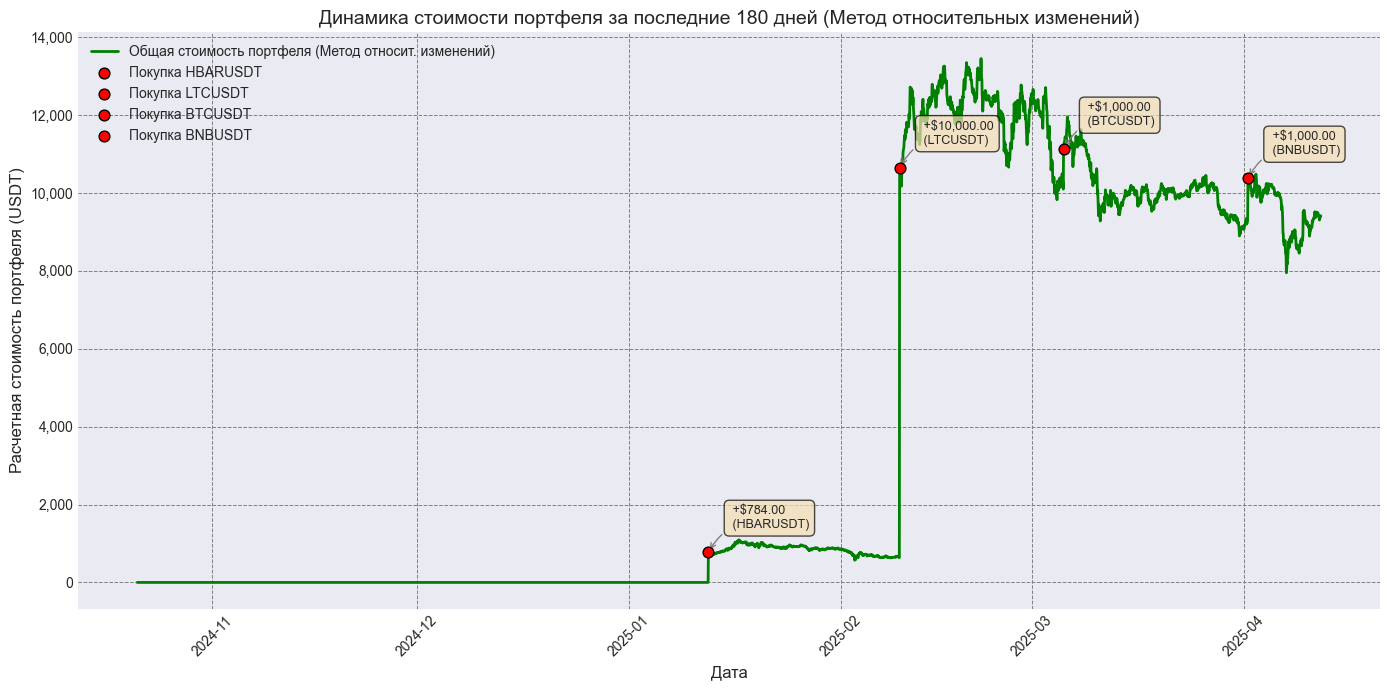


Данные портфеля с найденными ценами покупки:
                 Дата     Актив  Общая стоимость  Purchase_Price_Actual Actual_Purchase_Time_Index
0 2025-01-12 14:29:48  HBARUSDT            784.0                0.28239        2025-01-12 15:00:00
1 2025-02-09 14:21:24   LTCUSDT          10000.0              108.02000        2025-02-09 15:00:00
2 2025-03-05 14:21:17   BTCUSDT           1000.0            88344.25000        2025-03-05 15:00:00
3 2025-04-01 14:21:01   BNBUSDT           1000.0              615.26000        2025-04-01 15:00:00

Рассчитанные данные портфеля (первые 5 записей):
                     Total_Value_Relative  BNBUSDT_Price  BTCUSDT_Price  HBARUSDT_Price  LTCUSDT_Price
Open time                                                                                             
2024-10-21 00:00:00                   0.0          604.7       69160.00          0.0557          74.20
2024-10-21 01:00:00                   0.0          604.6       69210.89          0.0560          74.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

# --- Настройки ---
days_history = 180
# Укажите "сегодняшнюю" дату для отсчета истории назад
today = pd.Timestamp('2025-04-19')
# Либо, если ваши CSV обновляются, можно брать последнюю дату из данных:
# today = None # Раскомментируйте, если хотите использовать последнюю дату из данных

# --- Шаг 1: Загрузка данных о портфеле (используем Дату, Актив, Общую стоимость) ---
# Данные из вашего примера:
# 2 LTCUSDT $10,000.00
# 0 BNBUSDT $1,000.00
# 1 BTCUSDT $1,000.00
# 3 HBARUSDT $784.00
# Важно добавить соответствующие Даты покупок! Возьмем даты из предыдущего примера,
# но вам нужно будет их скорректировать под ваши реальные покупки.
portfolio_data = {
    "ID": [2, 0, 1, 3], # ID могут быть произвольными
    "Дата": ["2025-02-09T14:21:24.000", "2025-04-01T14:21:01.000", "2025-03-05T14:21:17.000", "2025-01-12T14:29:48.000"], # УКАЖИТЕ ВАШИ РЕАЛЬНЫЕ ДАТЫ ПОКУПОК!
    "Актив": ["LTCUSDT", "BNBUSDT", "BTCUSDT", "HBARUSDT"],
    "Общая стоимость": [10000.00, 1000.00, 1000.00, 784.00] # КЛЮЧЕВОЙ ПАРАМЕТР
    # Остальные столбцы из исходных данных портфеля не нужны для этого расчета
}
portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df['Дата'] = pd.to_datetime(portfolio_df['Дата'])
# Сортировка ОЧЕНЬ важна для правильной обработки покупок
portfolio_df = portfolio_df.sort_values(by='Дата').reset_index(drop=True)

# --- Шаг 2: Загрузка исторических данных активов ---
csv_base_path = 'D:\\__projects__\\diploma\\portfolios-optimization\\data'
try:
    # Укажите ПРАВИЛЬНЫЕ пути к вашим файлам CSV
    btc_data = pd.read_csv(f'{csv_base_path}\\BTCUSDT_hourly_data.csv')
    bnb_data = pd.read_csv(f'{csv_base_path}\\BNBUSDT_hourly_data.csv')
    ltc_data = pd.read_csv(f'{csv_base_path}\\LTCUSDT_hourly_data.csv')
    hbar_data = pd.read_csv(f'{csv_base_path}\\HBARUSDT_hourly_data.csv')
except FileNotFoundError as e:
    print(f"Ошибка: Файл не найден. Проверьте путь: {e}")
    # В Jupyter лучше не использовать exit(), а просто прервать выполнение
    raise SystemExit("Не удалось загрузить исторические данные.") from e

def preprocess_data(df, asset_name):
    # Ensure 'Open time' column exists
    if 'Open time' not in df.columns:
        print(f"Ошибка: Столбец 'Open time' не найден в данных для {asset_name}.")
        # Попытка найти похожий столбец (регистронезависимо)
        time_cols = [col for col in df.columns if 'time' in col.lower()]
        if time_cols:
            print(f"Используется найденный столбец времени: {time_cols[0]}")
            df.rename(columns={time_cols[0]: 'Open time'}, inplace=True)
        else:
            raise ValueError(f"Не удалось найти столбец времени для {asset_name}")

    df['Open time'] = pd.to_datetime(df['Open time'])
    df = df.set_index('Open time')

    # Ensure 'Close' column exists
    if 'Close' not in df.columns:
        print(f"Ошибка: Столбец 'Close' не найден в данных для {asset_name}.")
        # Попытка найти похожий столбец (регистронезависимо)
        close_cols = [col for col in df.columns if 'close' in col.lower()]
        if close_cols:
            print(f"Используется найденный столбец цен: {close_cols[0]}")
            df.rename(columns={close_cols[0]: 'Close'}, inplace=True)
        else:
             raise ValueError(f"Не удалось найти столбец цен (Close) для {asset_name}")

    # Нам нужен только столбец Close для цен
    df = df[['Close']].rename(columns={'Close': f'{asset_name}_Price'})
    # Явно указываем тип float
    df[f'{asset_name}_Price'] = df[f'{asset_name}_Price'].astype(float)
    return df

btc_data = preprocess_data(btc_data, 'BTCUSDT')
bnb_data = preprocess_data(bnb_data, 'BNBUSDT')
ltc_data = preprocess_data(ltc_data, 'LTCUSDT')
hbar_data = preprocess_data(hbar_data, 'HBARUSDT')

# Объединение данных по ценам
historical_prices = pd.concat([btc_data, bnb_data, ltc_data, hbar_data], axis=1)

# Определяем временной диапазон
if today is None:
    # Если today не задана, берем последнюю дату из ОБЪЕДИНЕННЫХ данных
    if not historical_prices.empty:
        today = historical_prices.index.max()
    else:
        print("Ошибка: Не удалось определить 'today', так как нет исторических данных.")
        raise SystemExit("Нет данных для определения временного диапазона.")
start_date_history = today - pd.Timedelta(days=days_history)

# --- Шаг 3: Фильтрация, подготовка и расчет стоимости (Метод относительных изменений) ---

# Фильтрация объединенных данных по заданному ИСТОРИЧЕСКОМУ диапазону
historical_prices_filtered = historical_prices[(historical_prices.index >= start_date_history) & (historical_prices.index <= today)].copy()
# Используем .copy() чтобы избежать SettingWithCopyWarning

# Заполнение возможных пропусков (важно перед поиском цен покупки)
# ffill - заполнить вперед, bfill - заполнить назад
historical_prices_filtered = historical_prices_filtered.ffill().bfill()

# Проверка на наличие NaN ПОСЛЕ заполнения
if historical_prices_filtered.isnull().values.any():
    print("Предупреждение: В исторических данных остались пропуски (NaN) после заполнения. Строки с NaN будут удалены.")
    print(historical_prices_filtered[historical_prices_filtered.isnull().any(axis=1)])
    historical_prices_filtered = historical_prices_filtered.dropna()

if historical_prices_filtered.empty:
     print(f"Ошибка: Нет исторических данных в диапазоне {start_date_history} - {today} после обработки пропусков. Проверьте даты и файлы.")
     raise SystemExit("Нет данных для анализа.")

# Добавляем столбцы для хранения цены покупки и индекса времени для каждой транзакции
portfolio_df['Purchase_Price_Actual'] = np.nan
portfolio_df['Actual_Purchase_Time_Index'] = pd.NaT

# Находим фактическую цену в исторических данных НА МОМЕНТ ПОКУПКИ или сразу после
print("Поиск цен на момент покупки...")
for index, row in portfolio_df.iterrows():
    asset = row['Актив']
    purchase_date = row['Дата']
    price_col = f'{asset}_Price'

    if price_col not in historical_prices_filtered.columns:
        print(f"Ошибка: Столбец цен {price_col} не найден для актива {asset} в отфильтрованных данных.")
        continue # Пропускаем эту покупку

    # Ищем первый индекс времени в historical_prices_filtered >= даты покупки
    relevant_prices = historical_prices_filtered[historical_prices_filtered.index >= purchase_date]

    if not relevant_prices.empty:
        actual_purchase_time_index = relevant_prices.index[0]
        # Получаем цену из строки, соответствующей найденному индексу времени
        purchase_price = historical_prices_filtered.loc[actual_purchase_time_index, price_col]

        # Проверка, что цена не NaN и не 0
        if pd.notna(purchase_price) and purchase_price > 0:
            portfolio_df.loc[index, 'Purchase_Price_Actual'] = purchase_price
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = actual_purchase_time_index
            # print(f"  Для {asset} ({purchase_date}): Найдена цена {purchase_price:.4f} на {actual_purchase_time_index}")
        else:
            print(f"Предупреждение: Найдена некорректная цена ({purchase_price}) для {asset} на {actual_purchase_time_index}. Покупка будет проигнорирована.")
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT # Помечаем как недействительное

    else:
        # Если дата покупки позже всех исторических данных в отфильтрованном диапазоне
        print(f"Предупреждение: Не найдены исторические данные для {asset} на или после {purchase_date} в диапазоне до {today}. Покупка будет проигнорирована.")
        portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT # Помечаем как недействительное

# Удаляем строки из портфеля, для которых не удалось найти действительное время/цену покупки
initial_portfolio_size = len(portfolio_df)
portfolio_df.dropna(subset=['Actual_Purchase_Time_Index', 'Purchase_Price_Actual'], inplace=True)
final_portfolio_size = len(portfolio_df)

print(f"\nНачальное кол-во покупок: {initial_portfolio_size}, учтено после поиска цен: {final_portfolio_size}")
if final_portfolio_size == 0:
      print("Ошибка: Не найдено действительных покупок для анализа. Проверьте Даты покупок в 'portfolio_data' и наличие соответствующих исторических данных в CSV файлах в указанном диапазоне.")
      raise SystemExit("Нет покупок для анализа.")

# Инициализируем столбец общей стоимости нулями
historical_prices_filtered['Total_Value_Relative'] = 0.0

# Рассчитываем стоимость для каждого момента времени
print("Расчет относительной стоимости портфеля...")
# Итерируемся по временным меткам в отфильтрованных данных
for current_time_index in historical_prices_filtered.index:
    current_total_value = 0.0
    # Итерируемся по каждой ДЕЙСТВИТЕЛЬНОЙ покупке в портфеле
    for _, purchase_row in portfolio_df.iterrows():
        purchase_time_index = purchase_row['Actual_Purchase_Time_Index'] # Фактическое время из индекса цен

        # Учитываем стоимость актива только если текущее время >= времени его покупки
        if current_time_index >= purchase_time_index:
            initial_investment = purchase_row['Общая стоимость'] # Исходная сумма инвестиции
            purchase_price = purchase_row['Purchase_Price_Actual'] # Фактическая цена в момент покупки
            asset = purchase_row['Актив']
            price_col = f'{asset}_Price'

            # Получаем текущую цену актива из отфильтрованных и заполненных данных
            current_price = historical_prices_filtered.loc[current_time_index, price_col]

            # Рассчитываем текущую стоимость этой конкретной инвестиции
            # на основе ПРОЦЕНТНОГО изменения цены с момента покупки
            if pd.notna(current_price) and current_price > 0: # Убедимся, что текущая цена действительна
                # Коэффициент изменения цены (Текущая Цена / Цена Покупки)
                # purchase_price > 0 проверено при фильтрации портфеля
                price_ratio = current_price / purchase_price
                current_investment_value = initial_investment * price_ratio
            else:
                # Если текущая цена все еще некорректна (маловероятно после ffill/bfill, но возможно на самом краю данных)
                # Используем последнюю рассчитанную стоимость этой инвестиции (приближенно)
                # Найдем предыдущую временную метку
                previous_indices = historical_prices_filtered.index[historical_prices_filtered.index < current_time_index]
                if not previous_indices.empty:
                    last_valid_time = previous_indices[-1]
                    # Попытаемся взять стоимость Total_Value_Relative *для этого актива* из предыдущего шага.
                    # Это сложно, проще сохранить предыдущую стоимость *всего* портфеля или обнулить вклад.
                    # Безопаснее считать вклад этой инвестиции в данный момент = 0, если цена неизвестна.
                    current_investment_value = 0
                    # print(f"Предупреждение: Отсутствует или некорректна текущая цена для {asset} на {current_time_index}. Вклад актива обнулен на этом шаге.")
                else:
                    # Если это самая первая точка и цена некорректна
                    current_investment_value = 0

            # Добавляем стоимость этой инвестиции к общей стоимости портфеля на текущий момент
            current_total_value += current_investment_value

    # Записываем общую стоимость портфеля для текущего времени
    historical_prices_filtered.loc[current_time_index, 'Total_Value_Relative'] = current_total_value

print("Расчет завершен.")

# --- Шаг 4: Визуализация ---
plt.style.use('seaborn-v0_8-darkgrid') # Стиль графика
fig, ax = plt.subplots(figsize=(14, 7)) # Создаем фигуру и оси

# График общей стоимости портфеля
ax.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Relative'],
        label='Общая стоимость портфеля (Метод относит. изменений)', color='green', linewidth=2)

# Добавление отметок о покупках
unique_labels_legend = set() # Для уникальных меток в легенде
# Фильтруем покупки, которые попадают в отображаемый временной диапазон графика
portfolio_in_range = portfolio_df[portfolio_df['Actual_Purchase_Time_Index'] >= historical_prices_filtered.index.min()]

for index, row in portfolio_in_range.iterrows():
    plot_time = row['Actual_Purchase_Time_Index']
    # Убедимся, что время покупки есть в индексе отфильтрованных данных
    if plot_time in historical_prices_filtered.index:
        # Стоимость портфеля в момент времени, соответствующий покупке
        value_at_purchase = historical_prices_filtered.loc[plot_time, 'Total_Value_Relative']
        label_text_marker = f'Покупка {row["Актив"]}'
        # Добавляем метку в легенду только один раз для каждого типа события
        current_label_for_legend = label_text_marker if label_text_marker not in unique_labels_legend else ""
        if current_label_for_legend: unique_labels_legend.add(label_text_marker)

        # Рисуем маркер покупки
        ax.scatter(plot_time, value_at_purchase,
                   color='red', s=60, zorder=5,
                   label=current_label_for_legend, marker='o', edgecolors='black') # zorder - чтобы маркер был поверх линии

        # Добавляем текст с информацией о покупке
        ax.annotate(f" +${row['Общая стоимость']:,.2f}\n ({row['Актив']})",
                    xy=(plot_time, value_at_purchase),
                    xytext=(15, 15), # Смещение текста от точки (в пикселях)
                    textcoords='offset points',
                    ha='left', va='bottom',
                    fontsize=9,
                    bbox=dict(boxstyle="round,pad=0.4", fc="wheat", alpha=0.7),
                    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.3", color='gray'))
    else:
         # Это может произойти, если Actual_Purchase_Time_Index не попал точно в индекс (маловероятно для hourly)
         print(f"Предупреждение: Не удалось найти точный индекс {plot_time} для отметки покупки {row['Актив']}")


# Настройка графика
ax.set_title(f'Динамика стоимости портфеля за последние {days_history} дней (Метод относительных изменений)', fontsize=14)
ax.set_xlabel('Дата', fontsize=12)
ax.set_ylabel('Расчетная стоимость портфеля (USDT)', fontsize=12)
ax.grid(True, which='major', linestyle='--', linewidth=0.7, color='grey')
ax.grid(True, which='minor', linestyle=':', linewidth=0.5, color='lightgrey')
ax.tick_params(axis='x', rotation=45, labelsize=10)
ax.tick_params(axis='y', labelsize=10)
# Форматирование оси Y без десятичных знаков и с разделителями тысяч
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# Создание и настройка легенды
handles, labels = ax.get_legend_handles_labels()
# Убедимся, что основной график тоже в легенде, если у него есть label
if 'Общая стоимость портфеля (Метод относит. изменений)' not in labels:
     # Добавляем его вручную, если scatter был первым
     line_handle = ax.get_lines()[0] # Получаем первый объект линии
     handles.insert(0, line_handle)
     labels.insert(0, line_handle.get_label())

by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='best', fontsize=10) # loc='best' пытается найти лучшее место

plt.tight_layout() # Автоматически корректирует поля графика
plt.show()

# --- Вывод данных для проверки ---
print("\nДанные портфеля с найденными ценами покупки:")
# Используем to_string() для лучшего форматирования в выводе ячейки
print(portfolio_df[['Дата', 'Актив', 'Общая стоимость', 'Purchase_Price_Actual', 'Actual_Purchase_Time_Index']].to_string())

print(f"\nРассчитанные данные портфеля (первые 5 записей):")
# Показываем итоговую стоимость и цены активов для сравнения
price_cols_to_show = sorted([f'{a}_Price' for a in portfolio_df['Актив'].unique() if f'{a}_Price' in historical_prices_filtered.columns])
print(historical_prices_filtered[['Total_Value_Relative'] + price_cols_to_show].head().to_string())

print(f"\nРассчитанные данные портфеля (последние 5 записей):")
print(historical_prices_filtered[['Total_Value_Relative'] + price_cols_to_show].tail().to_string())
